<a href="https://www.kaggle.com/code/archisha1207/notebook516b7f3af2?scriptVersionId=205700259" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)




In [2]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
#PreTrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping


# Other libraries
import os
import random

In [3]:
data = pd.read_csv("/kaggle/input/faces-age-detection-dataset/faces/train.csv")
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [4]:
data['Class'].value_counts()

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64

<Axes: >

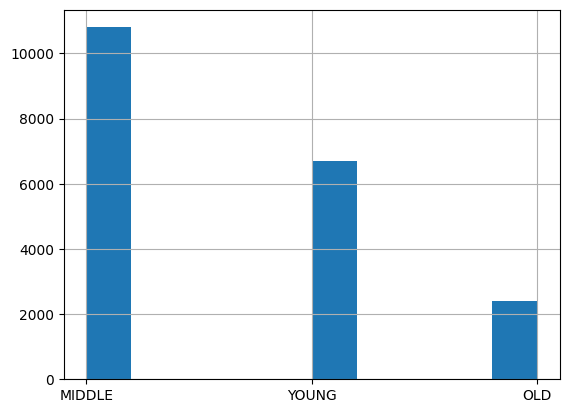

In [5]:
# Create a histogram for all categories in the class variable.
data['Class'].hist()

In [6]:
# Create file paths
directory = "/kaggle/input/faces-age-detection-dataset/faces/Train/"
data['filepath'] = directory + data['ID']

# Create DataFrame from the data
df_train = data[['filepath', 'Class']].rename(columns={'Class': 'label'})

# Check class distribution before splitting
print("Class distribution before splitting:")
print(df_train['label'].value_counts())

Class distribution before splitting:
label
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%), validation (10%), and test (10%) sets
train_df, dummy_df = train_test_split(df_train, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle=True, random_state=42)

# Print the shapes of the datasets
print(f"The shape of the Train data is: {train_df.shape}")
print(f"The shape of the Validation data is: {valid_df.shape}")
print(f"The shape of the Test data is: {test_df.shape}")

# Check class distribution in train_df
print("Class distribution in the Train data:")
print(train_df['label'].value_counts())

The shape of the Train data is: (15924, 2)
The shape of the Validation data is: (1991, 2)
The shape of the Test data is: (1991, 2)
Class distribution in the Train data:
label
MIDDLE    8623
YOUNG     5376
OLD       1925
Name: count, dtype: int64


In [8]:
# Convert integer labels to strings for the data generators
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [9]:
# Custom function to convert BGR to RGB
def bgr_to_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator without augmentation
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 80

# Create data generators
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Validation Data")
validation_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Test Data")
test_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Check the class indices to ensure they are correct
print("Class indices:", train_ds.class_indices)

Training Data
Found 15924 validated image filenames belonging to 3 classes.
Validation Data
Found 1991 validated image filenames belonging to 3 classes.
Test Data
Found 1991 validated image filenames belonging to 3 classes.
Class indices: {'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


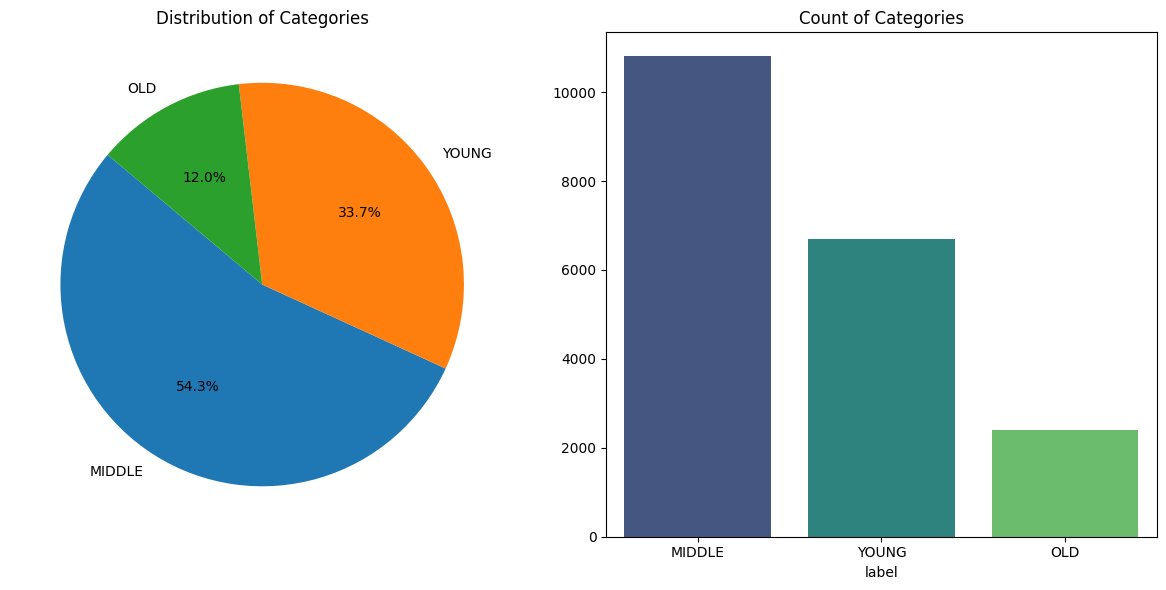

In [12]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

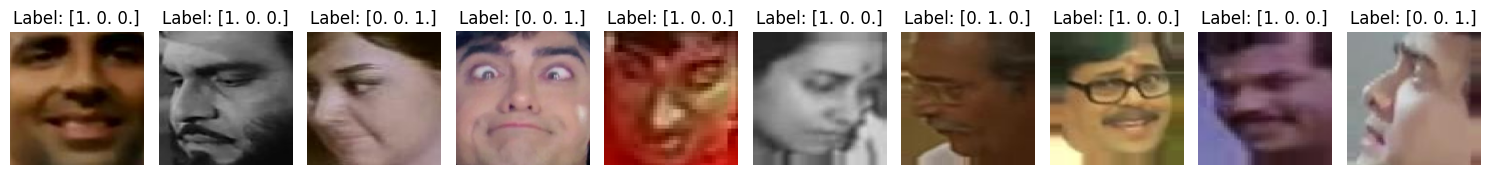

In [13]:
# Function to select and display random images
def display_random_images(generator, num_images):
    # Get batch of images and labels
    batch = next(generator)

    # Select random images from the batch
    selected_indices = random.sample(range(len(batch[0])), min(num_images, len(batch[0])))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, idx in enumerate(selected_indices):
        image = batch[0][idx]  # Get the image array from batch
        label = batch[1][idx]  # Get the corresponding label
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")  # Set label as title

 # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Assuming train_generator is your NumpyArrayIterator for the training set
# Display 5 random images from the training set
display_random_images(train_ds, 10)

In [14]:
# Define the class labels for AGE DETECTION classification
class_labels = train_ds.class_indices

# Print the class labels
print(f'Class labels: {class_labels}')

Class labels: {'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


In [15]:
from tensorflow.keras.applications import Xception

In [16]:
conv_base = Xception (
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Build Model
model = Sequential()

# Base Model
model.add(conv_base)

# Add Global Average Pooling to flatten the output from the base model
model.add(GlobalAveragePooling2D())

# Batch Normalization
model.add(BatchNormalization())

# Dense Layer 1
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Dense Layer 2
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer (number of classes should match your dataset)
model.add(Dense(3, activation='softmax'))  # Change the number of units to match the number of classes

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
import tensorflow as tf

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

In [21]:
history = model.fit(train_ds, epochs=50, validation_data=validation_ds,callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1730954773.197168      72 service.cc:145] XLA service 0x7a20dc001960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730954773.197223      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730954773.197227      72 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-07 04:46:29.933517: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[80,128,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[80,128,125,125]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-07 04:46:30.44619

107/200 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.4441 - loss: 7.2364

I0000 00:00:1730955051.041059      71 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 112 bytes spill stores, 112 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 80 bytes spill stores, 80 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 112 bytes spill stores, 112 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 88 bytes spill stores, 88 bytes spill loads



200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4942 - loss: 6.4990

2024-11-07 04:53:49.021479: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[71,128,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[71,128,125,125]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-07 04:53:49.381217: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.35992389s
Trying algorithm eng3{k11=2} for conv (f32[71,128,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[71,128,125,125]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue

200/200 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.4946 - loss: 6.4917 - val_accuracy: 0.6554 - val_loss: 2.7212
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.7038 - loss: 2.1246 - val_accuracy: 0.7675 - val_loss: 1.1931
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.7785 - loss: 0.9913 - val_accuracy: 0.7484 - val_loss: 0.8481
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.8174 - loss: 0.6798 - val_accuracy: 0.8282 - val_loss: 0.5781
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.8569 - loss: 0.4875 - val_accuracy: 0.8418 - val_loss: 0.5096
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.8736 - loss: 0.4209 - val_accuracy: 0.8383 - val_loss: 0.4853
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.8825 - loss: 0.3760 - val_accuracy: 0.7825 - val_loss: 0.5990
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.8765 - loss: 0.3908 - val_accuracy: 0.840